In [1]:
import numpy as np
import scipy
import pymysql
import os, sys, io
sys.path.append(os.path.abspath(os.path.dirname('../code/')))
from scipy.optimize import minimize
from Database import Database, Partition
import CostFunction
import Optimization.canberra_distance as canberra_distance
import math

CostFunction.py Not in Command line Mode


In [2]:
partition = Partition('PA')
database = Database(partition)
costfunction = CostFunction.CostFunction(database)

In [78]:
class SpecialtyWeight():
    
    def __init__(self, prescription):
        params = self.OrderParameters(prescription)
        self.order_number = self.find_order_number(params, prescription)
        self.params = params
    
    def OrderParameters(self, new_prescription):
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT MAX(specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar),
        specialty_mean_supply_per_claim / specialty_std_supply_per_claim,
        claim_per_dollar, supply_per_claim, pa_specialty_entropy.npi_count,
        pa_specialty_entropy.drug_count,
        pa_cost_function.npi_day_supply
        FROM pa_cost_function
        INNER JOIN claim_aggregates.pa_specialty_entropy ON 
        pa_specialty_entropy.specialty_description = pa_cost_function.specialty_description
        WHERE pa_cost_function.specialty_description = '{specialty_description}'
        ORDER BY MAX(specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar) DESC,
        specialty_mean_supply_per_claim / specialty_std_supply_per_claim DESC,
        claim_per_dollar DESC, supply_per_claim desc,
        pa_specialty_entropy.npi_count DESC,
        pa_specialty_entropy.drug_count DESC,
        pa_cost_function.npi_day_supply DESC
        LIMIT 0,1
        """.format(**new_prescription))
        max_values = dict(zip(['max', 'ratio','claim_per_dollar', 'supply_per_claim', 
                       'npi_count', 'drug_count', 'npi_day_supply'], cursor.fetchone()))
        cursor.close()
        return max_values
    
    def find_order_number(self, max_values, new_prescription):
        params = {**max_values, **new_prescription}
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT COUNT(*)
        FROM pa_cost_function
        INNER JOIN claim_aggregates.pa_specialty_entropy ON 
        pa_specialty_entropy.specialty_description = pa_cost_function.specialty_description
        WHERE (specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar) <= {max} AND
        (specialty_mean_supply_per_claim / specialty_std_supply_per_claim) <= {ratio} AND
        pa_specialty_entropy.npi_count <= {npi_count} AND
        pa_specialty_entropy.drug_count <= {drug_count} AND
        pa_cost_function.npi_day_supply <= {npi_day_supply} AND
        claim_per_dollar <= {claim_per_dollar} AND
        supply_per_claim <= {supply_per_claim}
        ORDER BY 
        pa_specialty_entropy.npi_count DESC,
        pa_specialty_entropy.drug_count desc,
        pa_cost_function.npi_day_supply DESC
        """.format(**params))
        length = cursor.fetchone()
        cursor.close()
        return length
    
class DrugWeight():
    
    def __init__(self, prescription):
        params = self.OrderParameters(prescription)
        self.order_number = self.find_order_number(params, prescription)
        self.params = params
    
    def OrderParameters(self, new_prescription):
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT MAX(specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar),
        specialty_mean_supply_per_claim / specialty_std_supply_per_claim,
        cost_per_claim, supply_per_claim,
        swd.prescribers, swd.part_d_claims, pct.total_day_supply
        FROM pa_cost_function
        INNER JOIN drug_aggregates.state_wise_drug_state swd
        ON swd.drug_name = pa_cost_function.drug_name AND
        swd.state = 'Pennsylvania'
        INNER JOIN drug_information.pa_cost_quality_table pct
        ON pct.specialty_description = pa_cost_function.specialty_description
        WHERE pa_cost_function.drug_name = '{drug_name}' AND swd.state = 'Pennsylvania'
        ORDER BY MAX(specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar) DESC,
        specialty_mean_supply_per_claim / specialty_std_supply_per_claim desc,
        cost_per_claim DESC, supply_per_claim DESC,
        swd.prescribers desc, swd.part_d_claims desc, pct.total_day_supply DESC
        LIMIT 0,1
        """.format(**new_prescription))
        max_values = dict(zip(['max', 'ratio', 'cost_per_claim', 'supply_per_claim', 'prescribers', 'part_d_claims', 
                       'total_day_supply'], cursor.fetchone()))
        cursor.close()
        return max_values
    
    def find_order_number(self, max_values, new_prescription):
        params = {**max_values, **new_prescription}
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT COUNT(*)
        FROM pa_cost_function
        INNER JOIN claim_aggregates.pa_specialty_entropy ON 
        pa_specialty_entropy.specialty_description = pa_cost_function.specialty_description
        INNER JOIN drug_aggregates.state_wise_drug_state swd
        ON swd.drug_name = pa_cost_function.drug_name AND
        swd.state = 'Pennsylvania'
        INNER JOIN drug_information.pa_cost_quality_table pct
        ON pct.specialty_description = pa_cost_function.specialty_description
        WHERE (specialty_std_claim_per_dollar / specialty_mean_claim_per_dollar) <= {max} AND
        (specialty_mean_supply_per_claim / specialty_std_supply_per_claim) <= {ratio} AND
        swd.prescribers <= {prescribers} AND
        swd.part_d_claims <= {part_d_claims} AND
        pct.total_day_supply <= {total_day_supply} AND
        cost_per_claim <= {cost_per_claim} AND
        supply_per_claim = {supply_per_claim} AND
        swd.state = 'Pennsylvania'
        ORDER BY 
        swd.prescribers DESC,
        swd.part_d_claims DESC,
        pct.total_day_supply DESC
        """.format(**params))
        number = cursor.fetchone()
        cursor.close()
        return number
        
def find_classes(prescription, table="pa_kmeans_y_pred_spl_weight"):
    cursor = database.opt_connection.cursor()
    cursor.execute("""
    SELECT COUNT(DISTINCT batch, cluster) as batch_cluster
    FROM """ + table + """
    WHERE drug_name = '{0}' AND specialty_description = '{1}'; """.format(prescription[0], prescription[1]))
    item = cursor.fetchone()
    cursor.close()
    return item[0]

def find_joint_classes(prescription, existing_prescription, table="pa_kmeans_y_pred_spl_weight"):
    cursor = database.opt_connection.cursor()
    cursor.execute("""
    SELECT COUNT(DISTINCT batch, cluster) as batch_cluster
    FROM """ + table + """
    WHERE (drug_name = '{0}' AND specialty_description = '{1}')
    OR (drug_name = '{2}' AND specialty_description = '{3}')
    """.format(prescription[0], prescription[1], existing_prescription[0], existing_prescription[1]))
    item = cursor.fetchone()
    cursor.close()
    return item[0]

def observation_values(selected_specialty, selected_drug):
    cursor = database.info_connection.cursor()
    cursor.execute("""
    SELECT npi, specialty_description, drug_name, total_claim_count, total_day_supply, drug_cost,
    total_claim_count / drug_cost as claim_per_dollar, total_day_supply / total_claim_count as supply_per_claim,
    drug_cost / total_claim_count as cost_per_claim
    FROM pa_state_spl_drug_npi
    WHERE specialty_description = '{0}' AND drug_name = '{drug_name}'
    """.format(selected_specialty, drug_name=selected_drug))
    specialty_values = cursor.fetchall()
    cursor.close()
    return specialty_values

def mean_values(selected_specialty, selected_drug):
    cursor = database.opt_connection.cursor()
    cursor.execute("""
    SELECT npi, specialty_description, drug_name,
    specialty_mean_claim_per_dollar, specialty_mean_supply_per_claim, specialty_mean_cost_per_claim,
    specialty_std_claim_per_dollar, specialty_std_supply_per_claim, specialty_std_cost_per_claim,
    AVG(), drug_mean_supply_per_claim, drug_mean_cost_per_claim,
    , drug_std_supply_per_claim, drug_std_cost_per_claim
    FROM pa_cost_function 
    INNER JOIN pa_state_spl_drug_npi ON
    pa_state_spl_drug_npi.specialty_description = pa_cost_function.specialty_description
    AND pa_state_spl_drug_npi.drug_name = pa_cost_function.drug_name
    WHERE pa_cost_function.specialty_description = '{0}' AND pa_cost_function.drug_name = '{drug_name}'
    GROUP BY pa_state_spl_drug_npi.specialty_description, pa_state_spl_drug_npi.drug_name
    """.format(selected_specialty, drug_name=selected_drug))
    aggregated_values = cursor.fetchone()
    cursor.close()
    return aggregated_values

class CanberraDistance():
        
    def __init__(self, canberra_npi):
        self.canberra_npi = canberra_npi

    def measure_distance(self, cluster_batch_data):
        canberra_cluster = []
        
        for item in cluster_batch_data:
            canberra_cluster.append(scipy.spatial.distance.canberra(self.canberra_npi, item[3:]))
        return canberra_cluster

class MMSEEstimation():

    def __init__(self, measurement_pair, observation_pair, optimizer):
        self.measurement_pair = measurement_pair
        self.observation_pair = observation_pair
        self.optimizer = optimizer

    def get_estimation_probability(self, cluster, batch, observation_pair, measurement_pair, table="pa_kmeans_y_pred_spl_weight"):
        prob_measurement = self.optimizer.probability_specialty_drug(measurement_pair, table=table)['calculated_probability']
        prob_observation_measurement = self.optimizer.cluster_batch_joint_probability_specialty_drug(
            measurement_pair, observation_pair, cluster, batch, table=table)['calculated_probability']
        prob_observation = self.optimizer.cluster_batch_probability_specialty_drug(
            observation_pair, cluster, batch, table=table)['calculated_probability']
        return [prob_measurement, prob_observation_measurement, prob_observation]
    
    def estimate_value(self, table="pa_kmeans_y_pred_spl_weight"):
        # Probability
        prob_measurement = self.optimizer.probability_specialty_drug(self.measurement_pair, table=table)['calculated_probability']
        prob_measurement_observation = self.optimizer.joint_probability_specialty_drug(
            self.measurement_pair, self.observation_pair, table=table)['calculated_probability']
        prob_observation = self.optimizer.probability_specialty_drug(self.observation_pair, table=table)['calculated_probability']

        # Observation
        observation_expectation = self.observation_quantity * prob_measurement_observation / prob_measurement
        return observation_expectation

    def measurement_expectation(self, table="pa_kmeans_y_pred_spl_weight"):
        # Probability
        prob_measurement = self.optimizer.probability_specialty_drug(self.measurement_pair, table=table)['calculated_probability']
        prob_observation_measurement = self.optimizer.joint_probability_specialty_drug(
            self.observation_pair, self.measurement_pair, table=table)['calculated_probability']
        prob_observation = self.optimizer.probability_specialty_drug(self.observation_pair, table=table)['calculated_probability']

        # Measurement
        measurement_expectation = self.measurement_quantity * prob_observation_measurement / prob_observation
        return measurement_expectation

    def set_data_points(self, measurement_values, estimation_values):
        self.measurement_quantity = measurement_values
        self.observation_quantity = estimation_values
        
    def calculate_covariance(self, estimation_values, start, end):
        measurement_values = self.measurement_quantity
        covariance_matrix = np.cov(np.mean(np.square(estimation_values[:, start:end] - phi_mean[start:end]), axis=0), 
                                   np.mean(np.square(measurement_values[:, start:end] - phi_mean[start:end]), axis=0))
        return covariance_matrix
    
    def predict_value(self, x_mean, y_mean, estimation_values, start):
        x_cap = x_mean[start] + (cov_xy / cov_y) * (estimation_values[:, start] - y_mean[start])
        return x_cap

class ClassificationCost():

    def __init__(self, x, y, xy, mutual_information, mmse):
        self.mutual_information = mutual_information
        self.x = x
        self.y = y
        self.xy = xy
        self.mmse = mmse
        
    def evaluate_priority(self, npi, cluster, batch, observation_pair, measurement_pair, table="pa_kmeans_y_pred_spl_weight"):
        # priority becomes our mmse estimation probability of observation given measurement
        probabilities = self.mmse.get_estimation_probability(cluster, batch, observation_pair, measurement_pair, table=table)
        if probabilities[2] == 0:
            return 0
        return probabilities[1] / probabilities[2]
        
    def evaluate_priority_with_covariance(self, npi, prescription):
        return None

    # Classify for claims
    def calculate_cost(self, prescription, cluster, batch, table='pa_kmeans_y_pred_spl_weight'):
        cursor = database.opt_connection.cursor()
        self.cluster = cluster
        self.batch = batch
        cursor.execute("""
        SELECT specialty_description, drug_name, npi FROM """ + table + """
        WHERE cluster = '{cluster}' AND batch = '{batch}'
        """.format(cluster=cluster, batch=batch))
        cluster_batches = np.array(cursor.fetchall())
        cursor.close()
        net_cluster = dict()
        net_cluster[cluster.__str__() + "__" + batch.__str__()] = 0 # Assigning priority for classification
        if len(cluster_batches) > 0:
            priority = 0
            total_claim = 0
            claim_array = []
            npi_collection = cluster_batches[:, 2]
            for npi in npi_collection.tolist():
                cursor = database.info_connection.cursor()
                cursor.execute("""
                SELECT total_claim_count FROM pa_state_spl_drug_npi
                WHERE npi = '{0}'
                """.format(npi))
                claim = cursor.fetchone()[0]
                claim_array.append(claim)
                cursor.close()
            idx = 0
            total_claim = sum(claim_array)
            for npi in npi_collection.tolist():
                priority = priority + self.mmse.optimizer.mutual_information(
                prescription=(cluster_batches[idx, 1], cluster_batches[idx, 0]),
                existing_prescription=(prescription["drug_name"],prescription["specialty_description"]),
                factor=0)*(1+1/((claim_array[idx]/total_claim)*(1+self.evaluate_priority(
                    npi,
                    cluster,batch,
                    (prescription["drug_name"], prescription["specialty_description"]),
                    (cluster_batches[idx, 1], cluster_batches[idx, 0]),table=table))))
                idx = idx + 1
        else:
            return 0

        return 1/len(cluster_batches) * priority

    def calculate_deviance(self, prescription, table='pa_kmeans_y_pred_spl_weight', optimization=None):
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT npi, specialty_description, drug_name, cluster, batch FROM
        """ + table + """
        WHERE specialty_description = '{specialty_description}' AND drug_name = '{drug_name}'
        """.format(**optimization.prescription))
        items = cursor.fetchall()
        cursor.close()
        value = 0
        try:
            for item in items:
                pi_c = self.calculate_cost(prescription, item[3], item[4], table=table)
                if pi_c != 0:
                    append_value = pi_c * math.log(pi_c)
                else:
                    append_value = 0
                value = value + append_value
        except Exception as e:
            print(pi_c)
            raise e
        return value

class Optimization():

    database = None
    total_batches = 52
    total_clusters = 300
    
    def __init__(self, db, prescription, state='PA', factor=None, table="pa_kmeans_y_pred_spl_weight"):
        database = db
        self.prescription = prescription
        self.table_name = table
        self.state = state
        self.factor = factor
        self.total_batches = self.calculate_net_cluster_size()
        self.canberra = CanberraDistance(canberra_distance.get_canberra_distance_npi(**prescription))
        
    def set_mmse(self, measurement_pair, observation_pair):
        self.mmse = MMSEEstimation(measurement_pair, observation_pair, self)
        return self.mmse
    
    def classification_cost(self, value, mmse, cluster, batch):
        cost = ClassificationCost(mutual_information=value, x=self.npix_specialty_drug_probability, 
                y=self.npiy_specialty_drug_probability, xy=self.joint_probability, mmse=mmse)
        return cost.calculate_cost(
            cluster=cluster, 
            batch=batch, 
            table='pa_kmeans_y_pred_drug_weight', 
            prescription=self.prescription)
        
    def calculate_net_cluster_size(self):
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT(batch)) as batch_size,
        COUNT(DISTINCT cluster) as cluster_size
        FROM """ + self.table_name + """
        """)
        results = cursor.fetchone()
        cursor.close()
        return results[0] * results[1]
    
    # Mutual Information for evaluating cost and quality
    def mutual_information(self, prescription, existing_prescription, factor):
        order_number = self.factor.order_number
        npix_specialty_drug_probability = self.probability_specialty_drug(prescription, table=self.table_name)
        npiy_specialty_drug_probability = self.probability_specialty_drug(existing_prescription, table=self.table_name)
        self.npix_specialty_drug_probability = npix_specialty_drug_probability
        self.npiy_specialty_drug_probability = npiy_specialty_drug_probability
        
        joint_probability = self.joint_probability_specialty_drug(prescription, existing_prescription, 
                                  table=self.table_name)
        self.joint_probability = joint_probability
        
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT (drug_cost / total_claim_count) / (total_day_supply / fill_count), npi FROM 
        pa_state_spl_drug_npi
        WHERE specialty_description = '{0}' AND drug_name = '{1}'
        """.format(prescription[1], prescription[0]))
        x_values = cursor.fetchall()
        cursor.close()
        
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) FROM pa_state_spl_drug_npi
        WHERE (drug_name = '{0}' AND specialty_description = '{1}')
        OR (drug_name = '{2}' AND specialty_description = '{3}')
        """.format(prescription[0], prescription[1], existing_prescription[0], existing_prescription[1]))
        joint_total = cursor.fetchone()
        joint_total = joint_total[0]
        cursor.close()
        
        value = 0
        for item in x_values:
            prob_xy = joint_total / ( joint_probability['net_drug_cases'] )
            over_x_value = item[0] * prob_xy * math.log( prob_xy / 
                  ((npix_specialty_drug_probability['specialty_drug_total'] / 
                    npix_specialty_drug_probability['drug_total']) * 
             (npiy_specialty_drug_probability['specialty_drug_total'] / 
              npiy_specialty_drug_probability['drug_total'])))
            value = value + over_x_value
        return value
    
    def cluster_batch_probability_specialty_drug(self, prescription, cluster, batch, 
                                                 table="pa_kmeans_y_pred_spl_weight"):
        if not prescription:
            prescription = self.prescription
        total_batches = self.total_batches
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + 
        """_state_spl_drug_npi WHERE drug_name = '{drug_name}' AND 
        specialty_description = '{specialty_description}'
        """.format(drug_name=prescription[0], 
            specialty_description=prescription[1]))
        drug_name = prescription[0]
        specialty_description = prescription[1]

        result = cursor.fetchone()
        specialty_drug_total = result[0]
        cursor.close()
        
        batch_cluster_sum = 0
        cursor = database.opt_connection.cursor()
        cursor.execute("""
        SELECT cluster, batch, npi FROM """ + table + """
        WHERE specialty_description = '{specialty_description}' AND drug_name = '{drug_name}'
        """.format(drug_name=prescription[0], specialty_description=prescription[1]))
        cluster_batches = np.array(cursor.fetchall())
        cursor.close()
        
        total_batches = len(cluster_batches)
        for item in cluster_batches:
            if item[0] == cluster and item[1] == batch:
                batch_cluster_sum = batch_cluster_sum + 1
        
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + """_state_spl_drug_npi
        WHERE drug_name = '{drug_name}'
        """.format(drug_name=drug_name))
        result = cursor.fetchone()
        drug_total = result[0]
        cursor.close()

        return {'calculated_probability': batch_cluster_sum * specialty_drug_total / (total_batches * drug_total),
               'batch_cluster_sum': batch_cluster_sum,
                'specialty_drug_total': specialty_drug_total,
                'drug_total': drug_total
               }
    
    def probability_specialty_drug(self, prescription=None, table="pa_kmeans_y_pred_spl_weight"):
        if not prescription:
            prescription = self.prescription
        total_batches = self.total_batches
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + 
        """_state_spl_drug_npi WHERE drug_name = '{drug_name}' AND 
        specialty_description = '{specialty_description}'
        """.format(drug_name=prescription[0], 
            specialty_description=prescription[1]))
        drug_name = prescription[0]
        specialty_description = prescription[1]

        batch_cluster_sum = find_classes(prescription, table=self.table_name)
        result = cursor.fetchone()
        specialty_drug_total = result[0]
        cursor.close()
        
        cursor = database.info_connection.cursor()
        cursor.execute("""
        SELECT COUNT(DISTINCT npi) as count FROM """ + partition.state + """_state_spl_drug_npi
        WHERE drug_name = '{drug_name}'
        """.format(drug_name=drug_name))
        result = cursor.fetchone()
        drug_total = result[0]
        cursor.close()
        
        return {'calculated_probability': batch_cluster_sum * specialty_drug_total / (total_batches * drug_total),
               'batch_cluster_sum': batch_cluster_sum,
                'specialty_drug_total': specialty_drug_total,
                'drug_total': drug_total
               }
    
    def joint_probability_specialty_drug(self, prescription, explore_prescription, table="pa_kmeans_y_pred_spl_weight"):
        x_prescription_combination = self.probability_specialty_drug(prescription, table=self.table_name)
        y_prescription_combination = self.probability_specialty_drug(explore_prescription, table=self.table_name)

        net_cases = x_prescription_combination['specialty_drug_total'] + y_prescription_combination['specialty_drug_total']
        net_drug_cases = x_prescription_combination['drug_total'] + y_prescription_combination['drug_total']
        batches_sum = find_joint_classes(prescription, explore_prescription, table=self.table_name)
        return {
            'net_cases': net_cases,
            'calculated_probability': batches_sum * net_cases / (self.total_batches * net_drug_cases),
            'net_drug_cases': net_drug_cases,
            'batches_sum': batches_sum,
            'net_y_cases': y_prescription_combination['specialty_drug_total']
        }
    
    def cluster_batch_joint_probability_specialty_drug(self, prescription, explore_prescription, cluster, batch, 
                                                      table="pa_kmeans_y_ped_specialty_weight"):
        x_prescription_combination = self.probability_specialty_drug(prescription, table=self.table_name)
        y_prescription_combination = self.cluster_batch_probability_specialty_drug(
            explore_prescription, cluster, batch, table=self.table_name)

        net_cases = x_prescription_combination['specialty_drug_total'] + y_prescription_combination['specialty_drug_total']
        net_drug_cases = x_prescription_combination['drug_total'] + y_prescription_combination['drug_total']
        batches_sum = find_joint_classes(prescription, explore_prescription, table=self.table_name)
        return {
            'net_cases': net_cases,
            'calculated_probability': batches_sum * net_cases / (self.total_batches * net_drug_cases),
            'net_drug_cases': net_drug_cases,
            'batches_sum': batches_sum,
            'net_y_cases': y_prescription_combination['specialty_drug_total']
        }

In [79]:
prescription = {"specialty_description": "Allergy/Immunology", "drug_name": "XOLAIR"}
drug_weight = DrugWeight(prescription)
sample_npi = '1629255443'
prescription['npi'] = sample_npi
drug_weight_opt = Optimization(database, prescription, state='PA', factor=drug_weight, 
                               table="pa_kmeans_y_pred_drug_weight")
print("The drug weight order parameters are: ", drug_weight.params)
print("The drug weight order number is : ", drug_weight.order_number)

negative_sample_npi = '1234567890'
comparison_prescription = {"specialty_description": "Allergy/Immunology", "drug_name": "NOVOLOG"}
comparison_prescription['npi'] = negative_sample_npi
cmp_drug_weight = DrugWeight(comparison_prescription)
cmp_drug_weight_opt = Optimization(database, comparison_prescription, state='PA', factor=cmp_drug_weight, 
                                  table="pa_kmeans_y_pred_drug_weight")

print("The drug weight order parameters are: ", cmp_drug_weight.params)
print("The drug weight order number is : ", cmp_drug_weight.order_number)

mmse_estimation = drug_weight_opt.set_mmse((prescription["drug_name"], prescription["specialty_description"]), 
                         (comparison_prescription["drug_name"], comparison_prescription["specialty_description"]))

# Data for the observatin points and estimation points
cursor = database.info_connection.cursor()
mmse_sql = """
SELECT npi, total_claim_count, bene_count, total_day_supply, drug_cost,
total_claim_count / drug_cost as claim_per_dollar, total_day_supply / total_claim_count as supply_per_claim,
drug_cost / total_claim_count as cost_per_claim
FROM pa_state_spl_drug_npi
WHERE specialty_description = '{0}' AND drug_name = '{1}'
"""
cursor.execute(mmse_sql.format(prescription["specialty_description"], prescription["drug_name"]))
measurement_mmse_data = cursor.fetchall()
cursor.close()

The drug weight order parameters are:  {'max': 1.3285592475904289, 'ratio': 2.3881377792573946, 'cost_per_claim': 1825.922142857143, 'supply_per_claim': 28.0, 'prescribers': 155, 'part_d_claims': 1722, 'total_day_supply': 184}
The drug weight order number is :  (25708,)
The drug weight order parameters are:  {'max': 2.020946153061685, 'ratio': 2.9625273960942424, 'cost_per_claim': 782.2792857142857, 'supply_per_claim': 34.107142857142854, 'prescribers': 6210, 'part_d_claims': 81816, 'total_day_supply': 728}
The drug weight order number is :  (1997,)


In [80]:
cursor = database.info_connection.cursor()
cursor.execute(mmse_sql.format(comparison_prescription["specialty_description"], comparison_prescription["drug_name"]))
observation_mmse_data = cursor.fetchall()
cursor.close()
if len(observation_mmse_data) == 0:
    print("The observation data for the prescription " + comparison_prescription.__str__() + " is negatively classed.")

mmse_estimation.set_data_points(measurement_mmse_data, observation_mmse_data)

# Which cluster and batch to measure in
mmse_batch = 25
mmse_cluster = 200

The observation data for the prescription {'specialty_description': 'Allergy/Immunology', 'drug_name': 'NOVOLOG', 'npi': '1234567890'} is negatively classed.


**This negatively classed item (because of non-existent prescription entry) is from the drug NOVOLOG.**

**There is no point in calculating the Joint Probability as the distribution does not have any quantities in the observation set. So, we can replace the New Prescription's Specialty to 'Physician Assistant'.**

In [81]:
comparison_prescription["specialty_description"] = "Physician Assistant"
comparison_prescription["npi"] = '1740378793'

## What is the Canberra distance of the new prescription in the classified batch and cluster
comparison_drug_factor = DrugWeight(comparison_prescription)
new_drug_weight_opt = Optimization(database, comparison_prescription, 'PA', factor=comparison_drug_factor, 
                                  table="pa_kmeans_y_pred_drug_weight")
mmse_drug_weight_opt = new_drug_weight_opt.set_mmse((prescription["drug_name"], prescription["specialty_description"]), 
                         (comparison_prescription["drug_name"], comparison_prescription["specialty_description"]))

cursor = database.info_connection.cursor()
cursor.execute(mmse_sql.format(comparison_prescription["specialty_description"], comparison_prescription["drug_name"]))
observation_comparison_mmse_data = cursor.fetchall()
cursor.close()
if len(observation_comparison_mmse_data) == 0:
    print("The observation data for the prescription " + comparison_prescription.__str__() + " is negatively classed.")
else:
    print("The observation data is of length: ", len(observation_comparison_mmse_data))
mmse_drug_weight_opt.set_data_points(measurement_mmse_data, observation_comparison_mmse_data)

cluster_batch_data = canberra_distance.get_cluster_batch_data(batch=mmse_batch, cluster=mmse_cluster, 
                                  table='pa_kmeans_y_pred_drug_weight')
cluster_distance = new_drug_weight_opt.canberra.measure_distance(cluster_batch_data)

The observation data is of length:  83


In [82]:
# Get all the clusters and batches in the Drug Weight clustering and plot the mutual information
classification_cost = []
mutual_information_array = []
factor_mutual_information_array = []
deviance = []
idx = 1
for item in cluster_batch_data:
    cursor = database.info_connection.cursor()
    cursor.execute("""
    SELECT (drug_cost / total_claim_count) / (total_day_supply / fill_count), npi FROM 
    pa_state_spl_drug_npi
    WHERE npi = '{0}' AND specialty_description = '{1}' AND drug_name = '{2}'
    ORDER BY (drug_cost / total_claim_count) / (total_day_supply / fill_count)
    LIMIT 0,1 
    """.format(item[2],item[0], item[1]))
    factor = cursor.fetchone()
    cursor.close()
    mutual_information = new_drug_weight_opt.mutual_information(
        (comparison_prescription["drug_name"], comparison_prescription["specialty_description"]),
        (item[1], item[0]), factor=factor)
    mutual_information_array.append(mutual_information)
    factor_mutual_information_array.append(factor[0] * mutual_information)
    idx = idx + 1

In [84]:
for idx in range(len(cluster_batch_data)):
    cost = new_drug_weight_opt.classification_cost(value=mutual_information_array[idx], mmse=mmse_drug_weight_opt, 
                       cluster=mmse_cluster, batch=mmse_batch)
    classification_cost.append(cost)

In [12]:
import pickle
pickle.dump(mutual_information_array, open("pickle\\mutual_information_array.pkl", "wb"))
pickle.dump(factor_mutual_information_array, open("pickle\\factor_mtual_information_array.pkl", "wb"))
pickle.dump(classification_cost, open("pickle\\classification_cost.pkl", "wb"))

In [87]:
idx = 0
for item in cluster_batch_data:
    cost = ClassificationCost(mutual_information=mutual_information_array[idx], 
          x=new_drug_weight_opt.npix_specialty_drug_probability, 
          y=new_drug_weight_opt.npiy_specialty_drug_probability, 
          xy=new_drug_weight_opt.joint_probability, mmse=mmse_drug_weight_opt)
    deviance_value = cost.calculate_deviance(comparison_prescription,
                table='pa_kmeans_y_pred_drug_weight', optimization=new_drug_weight_opt)
    deviance.append(deviance_value)
    idx = idx + 1

In [89]:
data = np.array(cluster_batch_data)
drug_weight = np.array(data[:, 9], dtype=np.dtype(np.float64))
spl_weight = np.array(data[:, 10], dtype=np.dtype(np.float64))
bene_risk = np.array(data[:, 11], dtype=np.dtype(np.float64))
health_risk_ratio = np.array(data[:, 15], np.dtype(np.float64))
npi = np.array(data[:, 2], np.dtype(np.float64))

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

In [90]:
plt.plot(drug_weight, npi, "r+-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

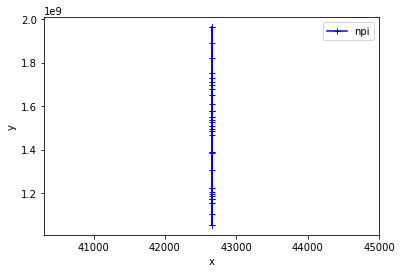

In [91]:
plt.plot(spl_weight, npi, "b+-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

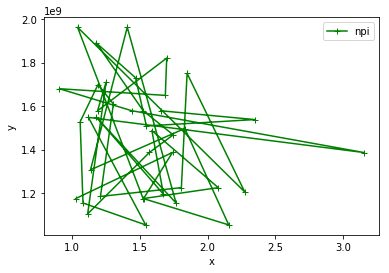

In [92]:
plt.plot(bene_risk, npi, "g+-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

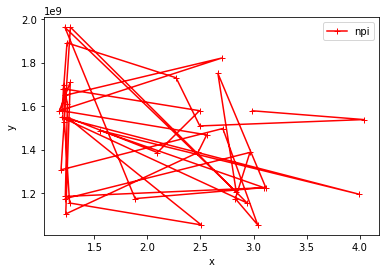

In [93]:
plt.plot(health_risk_ratio, npi, "r+-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [94]:
plt.plot(mutual_information_array, npi, "ko-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [95]:
plt.plot(factor_mutual_information_array, npi, "bo-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

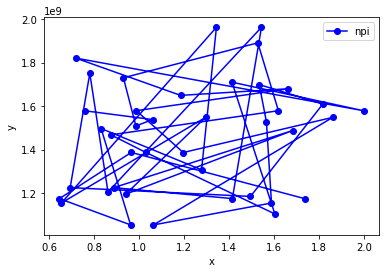

In [96]:
plt.plot(cluster_distance, npi, "bo-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

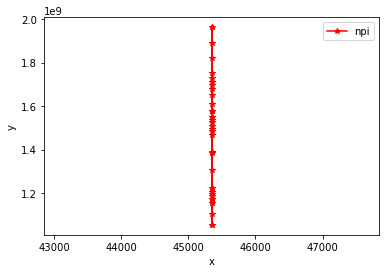

In [97]:
plt.plot(classification_cost, npi, "r*-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

**The classification cost is the same because of the equal mutual information, equal priority values as well. Given below is the data for cluster = '200' and batch = '25'.**

| specialty_description | drug_name | npi        | drug_weight | cluster | batch |
| --------------------- | --------- | ---------- | ----------- | ------- | ----- |
| Nurse Practitioner    | LANTUS    | 1174586119 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1386981793 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1174526719 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1053691857 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1497062632 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1306995659 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1962839340 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1154393460 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1548513328 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1194785162 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1487685608 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1225125230 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1174652127 | 0.007813614 | 200     | 25    |
| Nurse Practitioner    | LANTUS    | 1962634311 | 0.007813614 | 200     | 25    |
| ... | ... | ... | ... | ... | ... |

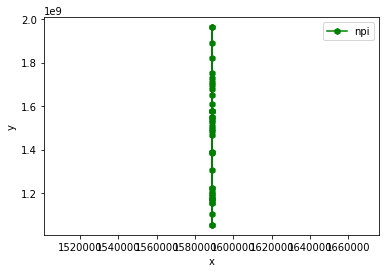

In [99]:
plt.plot(deviance, npi, "gh-", label="npi")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()